1. Data loading and cleaning
2. MLP for multiclass classification

### Multiclass Classification

In [189]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

data = pd.read_csv('data/air_quality/pollution.csv')
print(data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  


In [190]:
# Change Air quality from object to numeric value

air_quality = ['Hazardous', 'Poor', 'Moderate', 'Good']

data['Air Quality'] = data['Air Quality'].replace(air_quality, [0, 1, 2, 3])
data['Air Quality'] = data['Air Quality'].astype('int')


# Display a portion of the data

print(data['Air Quality'].head())


0    2
1    2
2    2
3    3
4    3
Name: Air Quality, dtype: int64


In [191]:
from sklearn.model_selection import train_test_split

X = data.drop('Air Quality', axis=1)
y = data['Air Quality']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

print(f'Number of samples in training set: {X_train.shape[0]}')
print(f'Number of samples in validation set: {X_val.shape[0]}')

Number of samples in training set: 4000
Number of samples in validation set: 500


In [192]:
# Try and rebalance the data by oversampling the minority classes

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=30)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

In [193]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_sm) 
X_test = scaler.transform(X_test_sm)
X_val = scaler.transform(X_val)

print(f'The length of the training dataset is: {len(X_train)}')
print(f'The length of the testing dataset is: {len(X_test)}')
print(f'The length of the validation dataset is: {len(X_val)}')

The length of the training dataset is: 6444
The length of the testing dataset is: 796
The length of the validation dataset is: 500


In [194]:
# Print one example of the observations:

print(f'variables: {X_train[0]} \n and target: {y_train_sm[0]}')

variables: [-0.79613145  1.47245708 -0.84727251 -0.5159942   0.51877226  0.04904326
  0.40750162 -0.18344172  1.02675971] 
 and target: 1


In [195]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MultiClass(Dataset):
    
    def __init__(self, X, y):

        self.X = X
        self.y = y
        
    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]


In [196]:
# Create the dataset

train_dataset = MultiClass(X_train, y_train_sm) # X_train_sm --> y_train_sm, X_train_us --> y_train_sm, X_train
test_dataset = MultiClass(X_test, y_test_sm)   # X_test_sm --> y_test_sm, X_test_us --> y_test_sm, X_test
val_dataset = MultiClass(X_val, y_val)

print(f'One sample of the dataset is: {test_dataset[0]}')

One sample of the dataset is: (array([-1.17208063e-03, -1.01062916e+00, -3.03492204e-01, -2.35705291e-01,
       -1.15450907e+00, -7.91720751e-01, -1.16069027e-01,  8.36824352e-01,
       -1.20278767e+00]), 2)


In [197]:
# Implement the Multilayer PErceptron
import torch.nn as nn
import torch.nn.functional as F

class MultiClassifier(nn.Module):
  def __init__(self, input_size):
    super(MultiClassifier, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size, 64), # Linear layer
        nn.ReLU(),                 # Relu activation function
        nn.Dropout(0.3),           # Dropout layer with 30% probability                                                
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),        # Batch Normalization layer
        nn.ReLU(),                                                       
        nn.Linear(64, 4),         # Linear layer with one neuron as output       
    )

  def forward(self, x):
    return self.model(x)

  
  def init_weights(self):
    for layer in self.model:
      if isinstance(layer, nn.Linear):
        #nn.init.xavier_uniform_(layer.weight) # Initialize weights with xavier uniform
        #nn.init.kaiming_normal_(layer.weight) # Initialize weights with kaiming normal
        nn.init.kaiming_uniform(layer.weight) # Initialize weights with kaiming uniform
        #nn.init.zeros_(layer.bias)        

In [198]:
from sklearn.metrics import accuracy_score

def fit_multiclassifier(model, dataloader, optimizer, criterion, phase):
  
  if phase == 'training':
    model.train()
  else:
    model.eval()

  running_loss = []
  running_accuracy = []
  for i, data in enumerate(dataloader):

    input = data[0].float().cuda(0)
    label = data[1].view(-1).long().cuda(0)

    if phase == 'training':
      optimizer.zero_grad()

    predictions = model(input)
    preds = torch.argmax(predictions, dim=1)
    
    loss = criterion(predictions, label)
    running_loss.append(loss.item())
    running_accuracy.append(accuracy_score(preds.cpu().numpy(), label.cpu().numpy()))
    
    if phase == 'training':
      loss.backward()         # Backpropagation
      optimizer.step()        # Update weights

  # Computing loss and accuracy
  total_loss = np.asarray(running_loss).mean()
  total_acc = np.asarray(running_accuracy).mean()

  return total_loss, total_acc

In [199]:
# Training proccess
import warnings
import sys
import time
warnings.filterwarnings("ignore")

input_size = X_train.shape[1]
num_epochs = 120
num_workers = 16
batch_size = 64

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4 # 1e-2
threshold = 0.5

# Load the data
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Load the model and the optimizer
mutliclass_model = MultiClassifier(input_size)
mutliclass_model.cuda(0)

optimizer = torch.optim.AdamW(mutliclass_model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=80, verbose=True)

loss_train = []
loss_valid = []

acc_train = []
acc_valid = []

prev_loss = []
 
# Learning forward loop
zero_time = time.time()
start_time = time.time()
for epoch in range(num_epochs):
    
    train_loss, train_acc = fit_multiclassifier(mutliclass_model, training_dataloader, optimizer, criterion, 'training')
    loss_train.append(train_loss), acc_train.append(train_acc)
    
    sys.stdout.flush()

    sys.stdout.write(f'Epoch {epoch + 1}/{num_epochs}, computed in {(time.time() - start_time):.3f} \n')
    start_time = time.time()

    sys.stdout.write(f'Training --> Loss: {train_loss:.3f}, Accuracy: {train_acc:.3f} \n')

    test_loss, test_acc = fit_multiclassifier(mutliclass_model, test_dataloader, optimizer, criterion, 'testing')
    loss_valid.append(test_loss), acc_valid.append(test_acc)

    scheduler.step(test_loss)  

    sys.stdout.write(f'Testing --> Loss: {test_loss:.3f}, Accuracy: {test_acc:.3f} \n\n')


print(f'Training completed in {((time.time() - zero_time)/70):.2} minutes')

Epoch 1/120, computed in 1.670 
Training --> Loss: 1.303, Accuracy: 0.377 
Testing --> Loss: 1.087, Accuracy: 0.646 

Epoch 2/120, computed in 2.235 
Training --> Loss: 0.993, Accuracy: 0.652 
Testing --> Loss: 0.849, Accuracy: 0.839 

Epoch 3/120, computed in 2.097 
Training --> Loss: 0.823, Accuracy: 0.745 
Testing --> Loss: 0.709, Accuracy: 0.863 

Epoch 4/120, computed in 2.405 
Training --> Loss: 0.714, Accuracy: 0.786 
Testing --> Loss: 0.601, Accuracy: 0.888 

Epoch 5/120, computed in 2.590 
Training --> Loss: 0.642, Accuracy: 0.811 
Testing --> Loss: 0.519, Accuracy: 0.900 

Epoch 6/120, computed in 2.482 
Training --> Loss: 0.578, Accuracy: 0.833 
Testing --> Loss: 0.471, Accuracy: 0.906 

Epoch 7/120, computed in 2.508 
Training --> Loss: 0.528, Accuracy: 0.846 
Testing --> Loss: 0.425, Accuracy: 0.917 

Epoch 8/120, computed in 2.283 
Training --> Loss: 0.485, Accuracy: 0.858 
Testing --> Loss: 0.375, Accuracy: 0.924 



KeyboardInterrupt: 

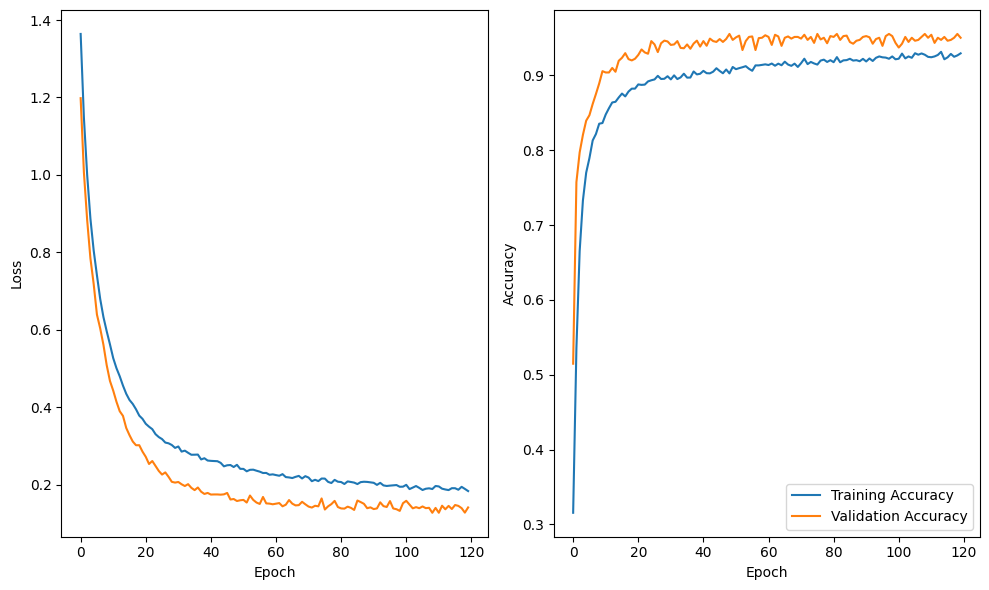

In [ ]:
# Plot the losses

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_train, label='Training Loss')
axes[0].plot(loss_valid, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(acc_train, label='Training Accuracy')
axes[1].plot(acc_valid, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# With the current model predict some instances
import torch

tot_pred = []
tot_lab = []
pred_prob = []

for i, instance in enumerate(test_dataloader):

    X_val = instance[0].float()
    label = instance[1].view(-1).numpy()

    with torch.no_grad():
        output = mutliclass_model.forward(X_val.cuda(0))

    preds = torch.argmax(output, dim=1).cpu().numpy()
    
    tot_pred.extend(preds)
    tot_lab.extend(label)

    for true, pred in zip(label, preds):
        
        match = "✔" if pred == true else "✘"
        print(f"Pred Vs Label: {pred} Vs {true} {match}, predicted output: {pred.item()}")

print(f'Total accuracy: {accuracy_score(tot_pred, tot_lab):.2f}')

[3 1 3 3 2 0 3 2 2 1 3 0 2 0 3 1 1 0 2 2 0 2 1 2 2 3 2 2 3 1 1 3 1 3 0 3 2
 0 1 2 0 0 2 0 2 2 2 2 0 0 3 2 2 2 2 0 1 2 3 1 2 3 1 1 2 2 3 0 2 1 2 1 3 0
 3 3 2 0 1 2 0 3 0 0 3 2 2 3 0 1 2 0 0 2 2 3 0 2 2 2 3 3 1 3 2 0 3 3 1 1 2
 3 1 2 1 2 2 3 2 1 1 3 2 3 3 3 3 3]
[3 1 3 3 2 0 3 2 2 1 3 0 2 0 3 0 1 0 2 2 1 2 1 2 2 3 2 2 3 1 1 3 1 3 0 3 2
 0 1 2 0 0 2 0 2 2 2 2 1 0 3 2 2 2 2 0 2 2 3 1 2 3 1 1 2 2 3 0 2 1 2 1 3 1
 3 3 2 0 1 2 0 3 0 0 3 2 2 3 0 1 2 0 0 2 2 3 0 2 2 2 3 3 1 3 2 0 3 3 1 1 2
 3 1 2 1 2 2 3 2 1 1 3 2 3 3 3 3 3]
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 1 Vs 1 ✔, predicted output: 1
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 1 Vs 1 ✔, predicted output: 1
Pred Vs Label: 3 Vs 3 ✔, pre